In [2]:
path_to_directory = "C:/Users/tiago/Desktop/DS/data_science_project"

file_tag = "class_ny_arrests"

train_filename = f"{path_to_directory}/datasets/{file_tag}_train_redundant.csv"
test_filename = f"{path_to_directory}/datasets/{file_tag}_test_redundant.csv"

# **Classification**
## **Evaluation**
### Training Strategies
#### train_test_split function

In [3]:
from numpy import array, ndarray
from pandas import read_csv, DataFrame

target = "JURISDICTION_CODE"
data_train: DataFrame = read_csv(train_filename)
data_test: DataFrame = read_csv(test_filename)

labels: list = list(data_train[target].unique())
labels.sort()
print(f"Labels={labels}")
print(data_train.shape)
print(data_test.shape)

positive: int = 1
negative: int = 0
values: dict[str, list[int]] = {
    "Original": [
        len(data_train[data_train[target] == negative])+len(data_test[data_test[target] == negative]),
        len(data_train[data_train[target] == positive])+len(data_test[data_test[target] == positive]),
    ]
}

y_trn: array = data_train.pop(target).to_list()
X_trn: ndarray = data_train.values

y_tst: array = data_test.pop(target).to_list()
X_tst: ndarray = data_test.values



Labels=[0, 1]
(80000, 15)
(20000, 15)


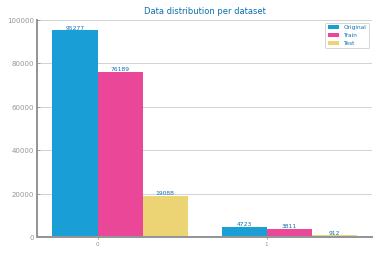

In [4]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart

#trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
trnX = X_trn
trnY = y_trn
tstX = X_tst
tstY = y_tst

train: DataFrame = concat(
    [DataFrame(trnX, columns=data_train.columns), DataFrame(trnY, columns=[target])], axis=1
)
train.to_csv(f"{path_to_directory}/datasets/{file_tag}_modeling_train.csv", index=False)

test: DataFrame = concat(
    [DataFrame(tstX, columns=data_test.columns), DataFrame(tstY, columns=[target])], axis=1
)
test.to_csv(f"{path_to_directory}/datasets/{file_tag}_modeling_test.csv", index=False)

values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

#### Reading Train and Test datasets

In [5]:
from pandas import read_csv


def read_train_test_from_files(
    train_fn: str, test_fn: str, target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    train: DataFrame = read_csv(train_fn, index_col=None)
    labels: list = list(train[target].unique())
    labels.sort()
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    test: DataFrame = read_csv(test_fn, index_col=None)
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values
    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()


train_filename = f"{path_to_directory}/datasets/{file_tag}_modeling_train.csv"
test_filename = f"{path_to_directory}/datasets/{file_tag}_modeling_test.csv"
eval_metric = "accuracy"

trnX: ndarray
tstX: ndarray
trnY: array
tstY: array
labels: list
vars: list
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(
    train_filename, test_filename, target
)
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

Train#=80000 Test#=20000
Labels=[0, 1]


### Estimators and Models

In [6]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(trnX, trnY)
pred_trnY: array = clf.predict(trnX)
print(f"Score over Train: {clf.score(trnX, trnY):.3f}")
print(f"Score over Test: {clf.score(tstX, tstY):.3f}")

Score over Train: 0.952
Score over Test: 0.955


### Evaluation
#### Accuracy, Recall and Precision

In [7]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

pred_tstY: array = clf.predict(tstX)

acc: float = accuracy_score(tstY, pred_tstY)
recall: float = recall_score(tstY, pred_tstY)
prec: float = precision_score(tstY, pred_tstY)
print(f"accuracy={acc:.3f} recall={recall:.3f} precision={prec:.3f}")

accuracy=0.955 recall=0.070 precision=0.566


#### Confusion Matrix

In [8]:
from pandas import unique
from sklearn.metrics import confusion_matrix

labels: list = list(unique(tstY))
labels.sort()

prdY: array = clf.predict(tstX)
cnf_mtx_tst: ndarray = confusion_matrix(tstY, prdY, labels=labels)
print(cnf_mtx_tst)

[[19039    49]
 [  848    64]]


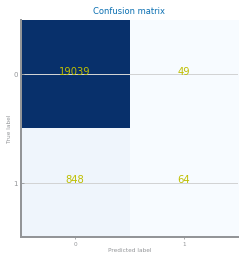

In [9]:
from itertools import product
from numpy import ndarray, set_printoptions, arange
from matplotlib.pyplot import gca, cm
from matplotlib.axes import Axes

def plot_confusion_matrix(cnf_matrix: ndarray, classes_names: ndarray, ax: Axes = None) -> Axes:  # type: ignore
    if ax is None:
        ax = gca()
    title = "Confusion matrix"
    set_printoptions(precision=2)
    tick_marks: ndarray = arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cnf_matrix, interpolation="nearest", cmap=cm.Blues)

    for i, j in product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        ax.text(
            j, i, format(cnf_matrix[i, j], "d"), color="y", horizontalalignment="center"
        )
    return ax

figure()
plot_confusion_matrix(cnf_mtx_tst, labels)
show()

#### ROC Charts

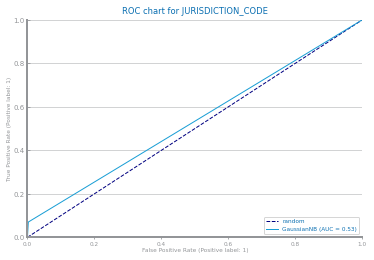

In [10]:
from sklearn.metrics import RocCurveDisplay
from config import ACTIVE_COLORS


def plot_roc_chart(tstY: ndarray, predictions: dict, ax: Axes = None, target: str = "class") -> Axes:  # type: ignore
    if ax is None:
        ax = gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel("FP rate")
    ax.set_ylabel("TP rate")
    ax.set_title("ROC chart for %s" % target)

    ax.plot(
        [0, 1],
        [0, 1],
        color="navy",
        label="random",
        linewidth=1,
        linestyle="--",
        marker="",
    )
    models = list(predictions.keys())
    for i in range(len(models)):
        RocCurveDisplay.from_predictions(
            y_true=tstY,
            y_pred=predictions[models[i]],
            name=models[i],
            ax=ax,
            color=ACTIVE_COLORS[i],
            linewidth=1,
        )
    ax.legend(loc="lower right", fontsize="xx-small")
    return ax


figure()
plot_roc_chart(tstY, {"GaussianNB": prdY}, target=target)
show()

<Figure size 432x288 with 0 Axes>

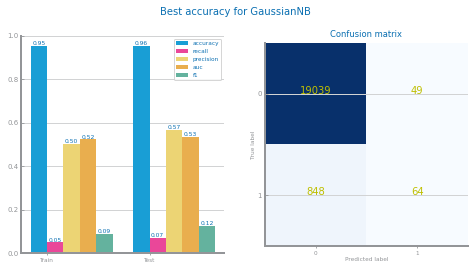

In [11]:
from typing import Callable
from matplotlib.figure import Figure
from matplotlib.pyplot import subplots, savefig, figure
from sklearn.metrics import roc_auc_score, f1_score
from dslabs_functions import plot_multibar_chart, HEIGHT

CLASS_EVAL_METRICS: dict[str, Callable] = {
    "accuracy": accuracy_score,
    "recall": recall_score,
    "precision": precision_score,
    "auc": roc_auc_score,
    "f1": f1_score,
}

def plot_evaluation_results(
    model, trn_y, prd_trn, tst_y, prd_tst, labels: ndarray
) -> ndarray:
    evaluation: dict = {}
    for key in CLASS_EVAL_METRICS:
        evaluation[key] = [
            CLASS_EVAL_METRICS[key](trn_y, prd_trn),
            CLASS_EVAL_METRICS[key](tst_y, prd_tst),
        ]

    params_st: str = "" if () == model["params"] else str(model["params"])
    fig: Figure
    axs: ndarray
    fig, axs = subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    fig.suptitle(f'Best {model["metric"]} for {model["name"]} {params_st}')
    plot_multibar_chart(["Train", "Test"], evaluation, ax=axs[0], percentage=True)

    cnf_mtx_tst: ndarray = confusion_matrix(tst_y, prd_tst, labels=labels)
    plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1])
    return axs

model_description: dict = {"name": "GaussianNB", "metric": eval_metric, "params": ()}

prd_trn: array = clf.predict(trnX)
prd_tst: array = clf.predict(tstX)
figure()
plot_evaluation_results(model_description, trnY, prd_trn, tstY, prd_tst, labels)
savefig(
    f'{path_to_directory}/images/{model_description["name"]}_best_{model_description["metric"]}_eval.png', bbox_inches='tight'
)

show()

## **Naive Bayes**
### Study Naive Bayes Alternatives

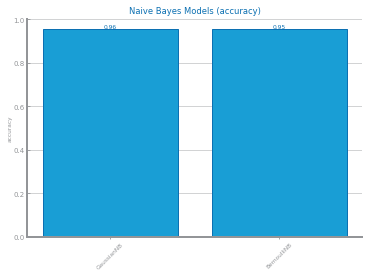

In [12]:
from numpy import array, ndarray
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_bar_chart


def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list = []
    yvalues: list = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance = 0
    for clf in estimators:
        xvalues.append(clf)
        estimators[clf].fit(trnX, trnY)
        prdY: array = estimators[clf].predict(tstX)
        eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval - best_performance > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["name"] = clf
            best_params[metric] = eval
            best_model = estimators[clf]
        yvalues.append(eval)
        # print(f'NB {clf}')
    plot_bar_chart(
        xvalues,
        yvalues,
        title=f"Naive Bayes Models ({metric})",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params


figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, eval_metric)
savefig(f"{path_to_directory}/images/Set 1 - NB {eval_metric} study.png", bbox_inches='tight')
show()

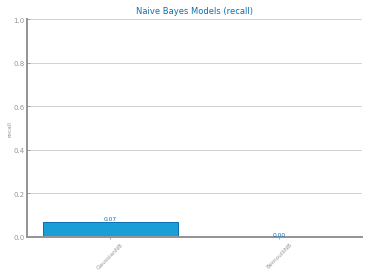

In [13]:
figure()
best_model, params = naive_Bayes_study(trnX, trnY, tstX, tstY, "recall")
savefig(f"{path_to_directory}/images/Set 1 - NB recall study.png", bbox_inches='tight')
show()

### Performance Analysis

<Figure size 432x288 with 0 Axes>

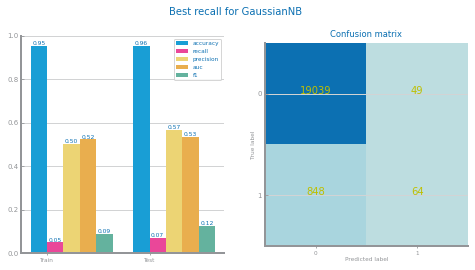

In [14]:
from dslabs_functions import plot_evaluation_results

prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'{path_to_directory}/images/Set 1 - NB {params["name"]} best {params["metric"]} eval.png', bbox_inches='tight')
show()

### Overfitting
Overfitting study is not usual in Naive Bayes models.

## **KNN**
### Paremeters study

Train#=80000 Test#=20000
Labels=[0, 1]
KNN best with k=3 and manhattan


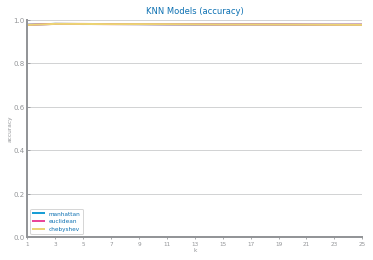

In [15]:
from typing import Literal, Union
from numpy import array, ndarray
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_multiline_chart
from dslabs_functions import read_train_test_from_files, plot_evaluation_results

def knn_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, k_max: int=19, lag: int=2, metric='accuracy'
        ) -> tuple[Union[KNeighborsClassifier, None], dict]:
    dist: list[Literal['manhattan', 'euclidean', 'chebyshev']] = ['manhattan', 'euclidean', 'chebyshev']

    kvalues: list[int] = [i for i in range(1, k_max+1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {'name': 'KNN', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance: float = eval
                best_params['params'] = (k, d)
                best_model = clf
            # print(f'KNN {d} k={k}')
        values[d] = y_tst_values
    print(f"KNN best with k={best_params['params'][0]} and {best_params['params'][1]}")
    plot_multiline_chart(kvalues, values, title=f'KNN Models ({metric})', xlabel='k', ylabel=metric, percentage=True)

    return best_model, best_params

eval_metric = 'accuracy'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)
savefig(f'{path_to_directory}/images/Set 1 - KNN {eval_metric} study.png', bbox_inches='tight')
show()

### Best model performance

<Figure size 432x288 with 0 Axes>

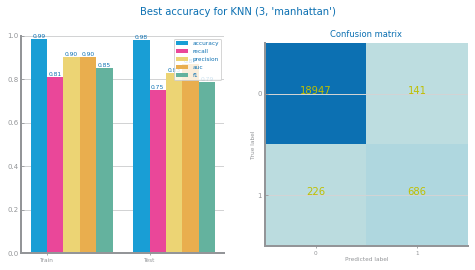

In [16]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'{path_to_directory}/images/Set 1 - KNN {params["name"]} best {params["metric"]} eval.png', bbox_inches='tight')
show()

### Overfitting study

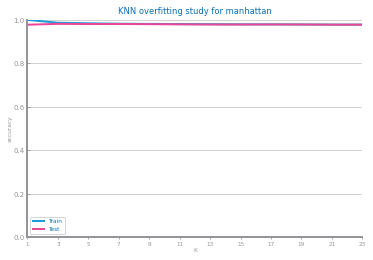

In [17]:
from matplotlib.pyplot import figure, savefig

distance: Literal["manhattan", "euclidean", "chebyshev"] = params["params"][1]
K_MAX = 25
kvalues: list[int] = [i for i in range(1, K_MAX, 2)]
y_tst_values: list = []
y_trn_values: list = []
acc_metric: str = "accuracy"
for k in kvalues:
    clf = KNeighborsClassifier(n_neighbors=k, metric=distance)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    kvalues,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"KNN overfitting study for {distance}",
    xlabel="K",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 1 - KNN overfitting.png", bbox_inches='tight')
show()

In this case, we don't see any overfitting, since the performance on both train and test sets keep the same trend.

## **Decision Trees**
### Paremeters study

Train#=80000 Test#=20000
Labels=[0, 1]
DT best with entropy and d=14


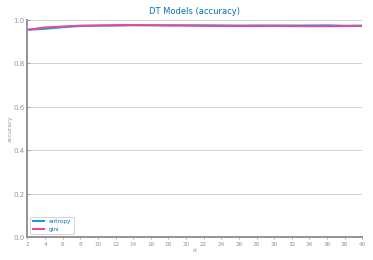

In [18]:
from typing import Literal
from numpy import array, ndarray
from matplotlib.pyplot import figure, savefig, show
from sklearn.tree import DecisionTreeClassifier
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, read_train_test_from_files
from dslabs_functions import plot_evaluation_results, plot_multiline_chart


def trees_study(
        trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, d_max: int=10, lag:int=2, metric='accuracy'
        ) -> tuple:
    criteria: list[Literal['entropy', 'gini']] = ['entropy', 'gini']
    depths: list[int] = [i for i in range(2, d_max+1, lag)]

    best_model: DecisionTreeClassifier | None = None
    best_params: dict = {'name': 'DT', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict = {}
    for c in criteria:
        y_tst_values: list[float] = []
        for d in depths:
            clf = DecisionTreeClassifier(max_depth=d, criterion=c, min_impurity_decrease=0)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance = eval
                best_params['params'] = (c, d)
                best_model = clf
            # print(f'DT {c} and d={d}')
        values[c] = y_tst_values
    print(f"DT best with {best_params['params'][0]} and d={best_params['params'][1]}")
    plot_multiline_chart(depths, values, title=f'DT Models ({metric})', xlabel='d', ylabel=metric, percentage=True)

    return best_model, best_params

eval_metric = 'accuracy'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train_filename, test_filename, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

figure()
best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=40, metric=eval_metric)
savefig(f'{path_to_directory}/images/Set 1 - DT {eval_metric} study.png', bbox_inches='tight')
show()

### Best model performance

<Figure size 432x288 with 0 Axes>

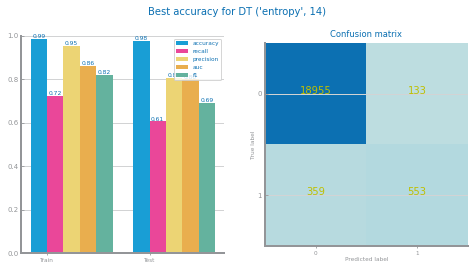

In [19]:
prd_trn: array = best_model.predict(trnX)
prd_tst: array = best_model.predict(tstX)
figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'{path_to_directory}/images/Set 1 - DT {params["name"]} best {params["metric"]} eval.png', bbox_inches='tight')
show()

### Variables importance

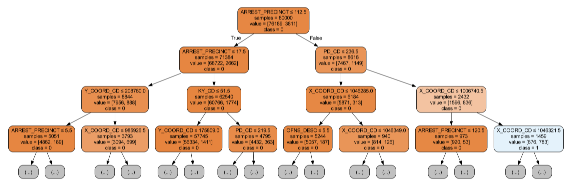

In [20]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"{path_to_directory}/images/Set 1 - DT {eval_metric} best tree"
max_depth2show = 3
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(10,4))
imshow(imread(tree_filename + ".png"))
axis("off")
show()

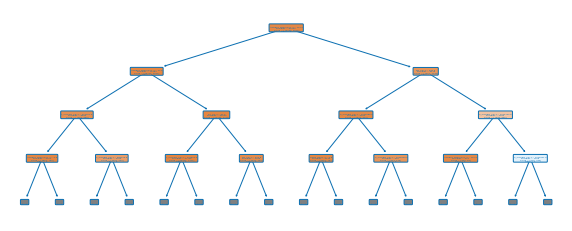

In [22]:
from sklearn.tree import plot_tree

figure(figsize=(10,4))
plot_tree(
    best_model,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + ".png", bbox_inches='tight')

1. X_COORD_CD (0.3618795198189003)
2. Y_COORD_CD (0.1990333951529713)
3. ARREST_PRECINCT (0.17149650017988644)
4. PD_CD (0.11501372235588417)
5. KY_CD (0.03199616628942055)
6. Day (0.027880124310463016)
7. OFNS_DESC (0.025326873351217406)
8. AGE_GROUP (0.016301899690309086)
9. Month_sin (0.01500096700965533)
10. Month_cos (0.014277139664394782)
11. PERP_RACE (0.01206801886410555)
12. PERP_SEX (0.0055854006923605525)
13. ARREST_BORO (0.003936143920964056)
14. Year (0.00020412869946737173)


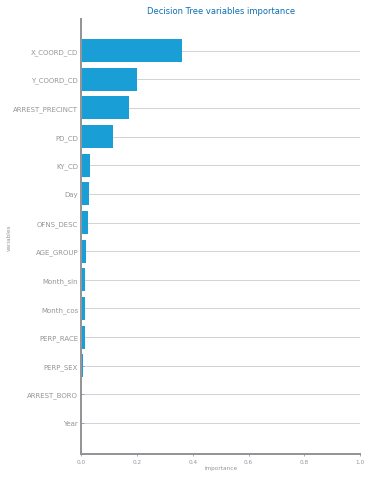

In [23]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure(figsize=(5, 8))
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title="Decision Tree variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 1 - DT {eval_metric} vars ranking.png", bbox_inches='tight')

### Overfitting study

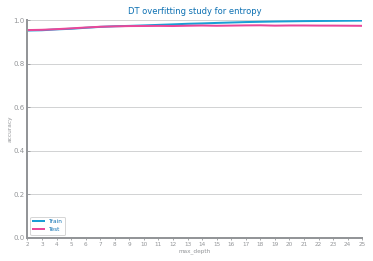

In [25]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"{path_to_directory}/images/Set 1 - DT {eval_metric} overfitting.png", bbox_inches='tight')

In this case, we don't see any overfitting, since the performance on both train and test sets keep the same trend.